
In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model, where $N$ is the observed count and $\theta$ is a nuissance parameter, hence the probability model is $P(N|\theta) = \text{Poisson}(N,\theta)$.
where the most important parameter is the cross section $\sigma$, which is related to the mean event count $N = \sigma \mathcal{L} +b$. 


### For the two-parameter problem, $n=\theta+\nu$, and the probability model is given by

$$p(n,m|\theta, \nu) = \text{Poiss}(n, \theta+\nu)\text{Poiss}(m,\nu) =L(\theta, \nu)= \frac{e^{-(\theta+\nu)} (\theta+\nu)^n }{n !} \ \frac{e^{-\nu} \nu^m}{m !}$$

Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest (for which we want to estimate upper limits).

In this notebook we generate data comprising the quadruplets $(Z_i, \theta_i, \nu_i, D_i)$ where 

$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \textrm{ and } \\
Z & = I[ \lambda_{\textrm{gen}} \leq \lambda_D (D, \theta) ],
\end{align}
$

where the size of each of these samples is $B'$, $I$ is the indicator function, and $\lambda_D (D, \theta)= \lambda(N, M, \theta)$.

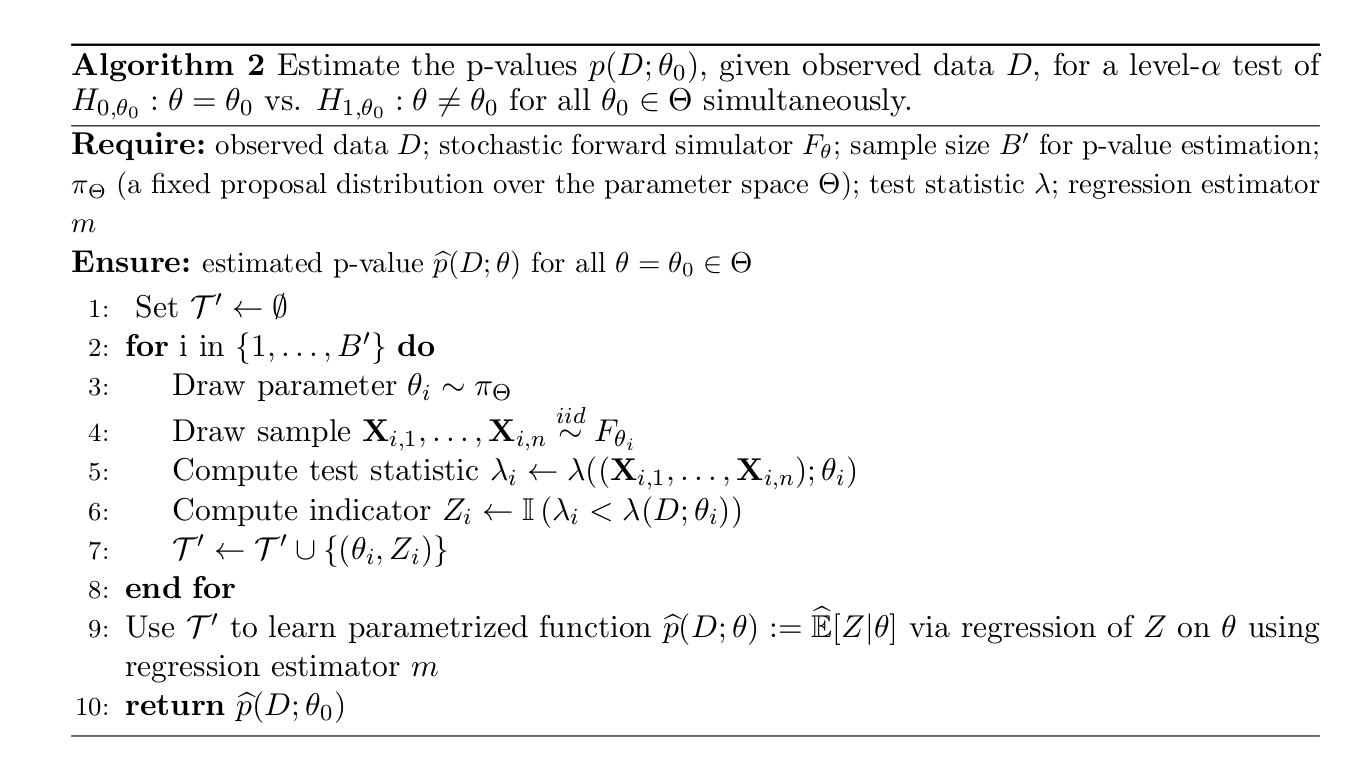

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
import matplotlib.pyplot as plt
# force inline plots
# %matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy
import pandas as pd
import sys
import os
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
def DR(s, theta):
    return sp.special.gammainc(s, theta)

def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)
from IPython.display import Image, display
algorithm2 = Image('src/images/Algorithm2.jpg')
display(algorithm2)

# Generate Data:
In this notebook we assume that $\hat{\theta}$ is given by its MLE. We generate data of size $B'$ according to our probability model:

$$P(n,m|\theta, \nu) = L(\theta, \nu) = \frac{e^{-(\theta+\nu)} (\theta+\nu)^n }{n !} \ \frac{e^{-\nu} \nu^m}{m !}$$

Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest.

Our test statistic will be:

$$ \lambda = -2 \log \frac{L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))}{L_{\text{prof}} (n, m, \hat{\theta}_{\text{MLE}}, \hat{\nu}(\theta))}$$

Where $L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))$ is the profiled likelihood. The maximum likelihood estimate of $\hat{\theta}$, 
$$\hat{\theta}_{\text{MLE}}=n-m$$, and

$$\log{p(n,m|\theta,\nu)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$
The MLE $\hat{\nu}(\theta)$ is attained by solving $\frac{\partial \log{p(n,m|\theta,\nu)}}{ \partial \nu} =0$ leading to 

$$\hat{\nu}(\theta)=\left(g+\sqrt{g^2 + 8 m \theta} \right)/4$$
where $g \equiv n+m-2 \theta$

Compute the profile likelihood $L_{\text{profile}} = p(n,m|\theta, \hat{\nu}(\theta) )=L_{\text{prof}}(n,m,\theta )$

In [4]:
k=1
def L_prof(n,m,theta):
    k=1
    k1 = k+1
    k2 = 0.5/k1
    g = n+m - k1*theta
    nu_hat = k2* (g+ np.sqrt(g*g +4*k1*m*theta))
    p1 = st.poisson.pmf(n, mu = theta + nu_hat)
    p2 = st.poisson.pmf(m, mu = k * nu_hat)
    
    return p1*p2

Compute $\hat{\theta}$
1. MLE: $\hat{\theta}(n,m) = n-m$
2. non-MLE: $\hat{\theta}(n,m)=n-m$ if $n>m$, else $0$

Again, in this notebook we use $\hat{\theta}_{\text{MLE}}=\hat{\theta}_{\text{MLE}}(n,m)$

In [5]:
def theta_hat(n,m, MLE=True):
    theta_hat = n-m
    
    if not MLE:
        theta_hat = theta_hat * (theta_hat > 0)
    return theta_hat

Compute 
$$ \lambda (\theta, n, m, k) = - 2 \log{\frac{p(n,m|\theta, \hat{\nu}(\theta) )}{ p(n,m|\hat{\theta}, \hat{\nu}(\theta) )}} = -2 \log{\frac{L_{\text{profile}} (\theta, \hat{\nu}(\theta))}{L_{\text{profile}} (\hat{\theta}(n,m), \hat{\nu}(\theta))}}$$

In [6]:
def lambda_test(theta, n, m, MLE=True):
    Ln = L_prof(n,m,theta)
    Ld = L_prof(n,m, theta_hat(n,m, MLE))
    t  = -2*np.log(Ln/Ld)
    return t

# def run_one_simulation(theta0, theta, nu, MLE, Bprime=Bprime):
#     #sample n from a Poisson with mean theta+nu
#     n = st.poisson.rvs(theta+ nu, size=Bprime)
#     #sample m from a poisson with mean k*nu
#     m = st.poisson.rvs(k*nu, size=Bprime)
    

In [7]:
def run_sim( theta, nu):
    n = st.poisson.rvs(theta+nu, size=400)
    m = st.poisson.rvs(nu, size=400)
    lambda_t = lambda_test(theta, n, m, MLE)
    return (n, m, lambda_t)

def run_sims(points):
    t_results=[]

    for p in points:
        theta, nu = p
        n, m, t = run_sim(theta, nu)
        t_results.append((n, m, t, theta, nu))
        print((theta, nu))
    return t_results


def plot_one(t, theta, nu, ax):
    ftsize = 16
    xmin= 0
    xmax= 10
    ymin= 0
    ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel(r'$t$',fontsize=ftsize)
    ax.set_ylabel(r'cdf$(t)$', fontsize=ftsize)
    ax.hist(t, bins=5*xmax, range=x_range,
    color=(0.8,0.8,0.9), alpha=0.3,
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black')
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 1)
    ax.plot(x, y, color='blue',
    linewidth=2)
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid/2
    ypos = ymin + ywid*2
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
def plot_all(results, fgsize=(10,6)):
    plt.figure(figsize=fgsize)
    fig, ax = plt.subplots(2, 3, figsize=fgsize)
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.2)
    ax = ax.flatten()
    
    for i, result in enumerate(results):
        n, m, t, theta, nu = result
        plot_one(t, theta, nu, ax[i])
    for j in range(len(results), len(ax)):
        ax[j].set_visible(False)
        
    plt.tight_layout()
    plt.show()
    

In [9]:
MLE=True
points = [(theta, nu) for theta, nu in 
          zip(np.random.randint(low=1,high=4,size=4), np.random.randint(low=0,high=4,size=4))]

results = run_sims(points)

(3, 2)
(1, 3)
(1, 2)
(1, 1)


<Figure size 720x432 with 0 Axes>

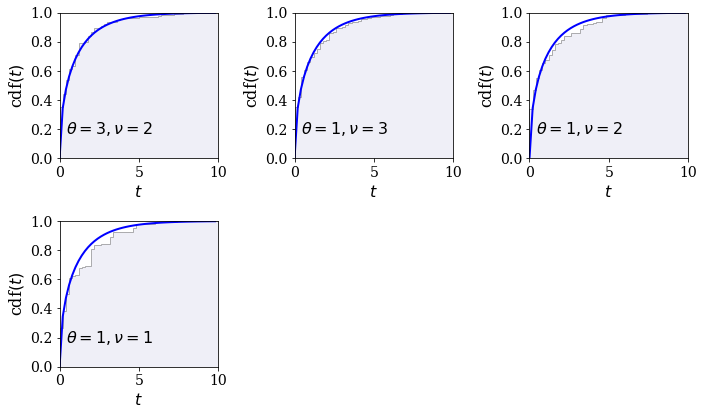

In [10]:
plot_all(results)

In [138]:
Bprime    = 1000000
thetaMin, thetaMax =  0, 20
nuMin, nuMax = 0, 20
Mmin, Mmax =  0, 30
Nmin, Nmax =  0,30
MLE=True
def generate_training_data(Bprime, save_data=False):
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator
    #sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    
    #sample our observed counts (N,M), which take the place of D
    N = st.uniform.rvs(Nmin, Nmax, size=Bprime)
    M = st.uniform.rvs(Mmin, Mmax, size=Bprime)
    print('N=', N)
    lambda_gen = lambda_test(theta, n, m, MLE)
    print('lambda_gen= ', lambda_gen)
    lambda_D = lambda_test(theta, N, M, MLE)
    print('lambda_D= ', lambda_D)
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'Z' : Z, 'theta' : theta, 'nu': nu, 'N':N, 'M':M}

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    if save_data:
        data_2_param.to_csv('../data/two_parameters'+'D_Uniformly_sampled.csv')

    print(data_2_param.head())
    return data_2_param

In [139]:
data_2_param=generate_training_data(Bprime)

lambda_gen=  [0.46515171 0.03940588 1.43268902 ... 2.56776526 4.45425138 0.2138339 ]
lambda_D=  [nan nan nan ... nan nan nan]
   Z      theta         nu          N          M
0  0   1.052295  12.321467  18.341042  27.813310
1  0   6.349584   1.962004  26.785112   4.629225
2  0   5.445874   7.742827  12.232916  15.771406
3  0  12.766647  11.008462   6.776230   9.423360
4  0  17.484448   1.743832   4.735776  29.317890


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [133]:
np.sum(data_2_param.Z)/len(data_2_param.Z)

0.0

In [58]:
# Fraction of the data assigned as test data
fraction = 1/102
inputs = ['theta', 'nu', 'D']
data = data_2_param
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 1/101
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes and drop the old ones
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5][inputs]

train set size:         98038
validation set size:      981
test set size:            981


,theta,nu,D
0,13.325334,4.919686,7
1,14.741477,22.288468,2
2,19.802117,23.883361,8
3,5.965202,8.937730,2
4,2.091632,4.027647,4


In [59]:
def split_t_x(df, inp=inputs):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df['Z'])
    x = np.array(df[inp])
    return (t, x)

train_t, train_x = split_t_x(train_data)
valid_t, valid_x = split_t_x(valid_data)
test_t,  test_x  = split_t_x(test_data)

In [62]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = rnd.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t)

In [63]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()      
    return (xx, yy_t, yy_v)

In [64]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

In [72]:
import torch
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, n_inputs=3, n_nodes=20, n_layers=5):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y

In [73]:
model = Model()
print(model)

Model(
  (layer0): Linear(in_features=3, out_features=20, bias=True)
  (layer1): Linear(in_features=20, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=1, bias=True)
)


In [74]:
learning_rate = 1.e-3
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ([], [], [])
traces_step = 10

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.278885	  0.278205
     19990	  0.194634	  0.194477
Iteration vs average loss
 iteration	 train-set	 valid-set
     29990	  0.193980	  0.193748


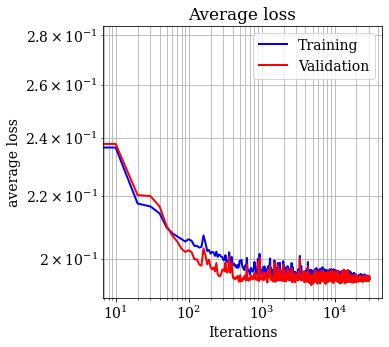

In [75]:
n_batch       = 50
n_iterations  = 20000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

n_batch       = 500
n_iterations  = 10000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

plot_average_loss(traces)

In [78]:
def plot_data(data, func, Dmin, Dmax, x, 
              #gfile='fig_data.png', 
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, d in enumerate(range(Dmin, Dmax+1)):
        
        # compute DL 
        y, p = func(data, d, x)
        # "func" is the function used as an input, in this case it is hist_data, which returns (y, p), where y is weighted_histogram/unweighted_histoggram, p is the exact p value
        
        ax[j].set_xlim(xmin, xmax)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta)$', fontsize=FONTSIZE)
        
        ax[j].plot(x, y, 'b', lw=2, label='approx')
        ax[j].plot(x, p, 'r', lw=2, label='exact')
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(12, 0.42, r'$D = %d$' % d, fontsize=FONTSIZE) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(Dmax+1-Dmin, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.savefig(gfile)
    plt.show()

In [87]:
test_x#.theta#, test_data.nu, test_data.
test_x.shape

(981, 3)

In [93]:
xmin, xmax = 0, 20
xrange= (xmin, xmax)
xbins = 40
xstep = (xmax - xmin) / xbins
# x     = np.arange(xmin+0.5*xstep, xmax + 0.5*xstep, xstep)

def usemodel(data, d, x):
    model.eval()
    # xx= [[x.theta, x.nu, x.D] for z in x]
    xx=test_x
    X = torch.Tensor(xx)
    y = model(X).detach().numpy()
    p = DL(d, x)
    return (y, p)

IndexError: index 6 is out of bounds for axis 0 with size 6

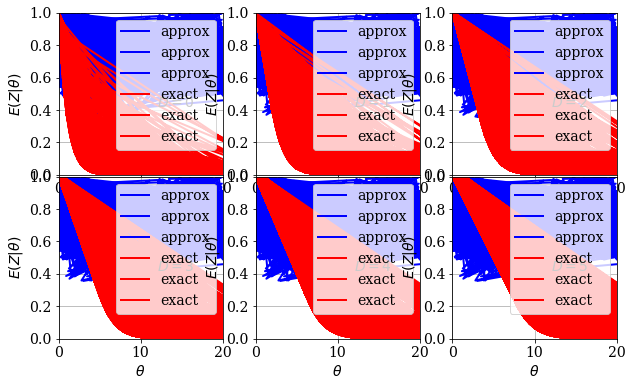

In [94]:
plot_data(data, usemodel, Dmin, Dmax, test_x) 